In [88]:
from typing import Iterable
import datetime

In [38]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import rdkit
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
print(rdkit.__version__)

2023.09.1


In [93]:
def enumerate_tauts_v1(sml):
    start = datetime.datetime.now()
    smls_tauts = []
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    for enumerator in enumerators:
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        smls = {Chem.MolToSmiles(x) for x in tauts}
        smls_tauts.append({sml:taut for sml, taut in zip(smls,tauts)})
    # print(f"enumerate_tauts took {datetime.datetime.now() - start} seconds")
    return smls_tauts

In [103]:
def enumerate_tauts_v2(sml):
    smls_tauts = []
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    for i, enumerator in enumerate(enumerators):
        smls_tauts.append(dict())
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [108]:
def enumerate_tauts(sml):
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    smls_tauts = [{} for _ in enumerators]
    for i, enumerator in enumerate(enumerators):
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [91]:
def check_same_keys(dict_list):
    start = datetime.datetime.now()
    # Check if the list is empty or has only one dictionary
    if len(dict_list) < 2:
        return True

    # Get the keys of the first dictionary in the list
    reference_keys = set(dict_list[0].keys())

    # Iterate through the dictionaries starting from the second one
    for dictionary in dict_list[1:]:
        # Check if the keys of each dictionary match the keys of the reference dictionary
        if set(dictionary.keys()) != reference_keys:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    # print(f"check_same_keys took {datetime.datetime.now() - start} seconds")
    return True

Algorithm for processing Tautomer_database_release_3a:
1) Remove duplicate (keep only one row) Ref values--at initial inspection, seems like duplicate rows contain the same SMILES for SMILES_n
2) For each (remaining) row,
    1) Read Size value
    2) Extract columns SMILES_n where n = 1 to Size
    3) Convert extracted SMILES_n to canonical using RDKit
    4) Use those several SMILES_n columns as experimental tautomers by creating a set of SMILES_n (or dictionary of SMILES_n:mol ?)
    5) Use only SMILES_1 to enumerate tautomers using various cheminformatics algorithms
    6) Compare experimental to cheminformatics results: Are there differences in count and canonical SMILES?

In [110]:
file_name = "../data/8.sk.smi"
# file_name = "../data/12.sk.smi"

In [77]:
df = pl.read_csv(file_name, has_header=False)
df.columns = ["sml"]

In [114]:
df = pl.read_csv(file_name, has_header=False)
df.columns = ["sml"]
print(df)
# df = df.slice(0, 5_000)
df = df.with_columns(
    [
        # pl.col("sml").map_elements(lambda sml: check_same_keys(enumerate_tauts(sml))).alias("same_tauts"),
        pl.col("sml").map_elements(lambda sml: len(enumerate_tauts(sml)[0])).alias("n_tauts"),
    ]
)
# df_diff_tauts = df.filter(pl.col("same_tauts") == False)
# df_diff_tauts
df_multiple_tauts = df.filter(pl.col("n_tauts") == 1)
df_multiple_tauts

shape: (1_274, 1)
┌─────────────────┐
│ sml             │
│ ---             │
│ str             │
╞═════════════════╡
│ C1C2CC1C=CC=C2  │
│ C1C2C3CC1C=CC23 │
│ C1C2CC3C=CC2C13 │
│ C1C2C1C1CC2C=C1 │
│ …               │
│ CCCCCC(C)=C     │
│ CCCCCC#CC       │
│ CCCCCCC=C       │
│ CCCCCCC#C       │
└─────────────────┘


sml,n_tauts
str,i64
"""C1C2CC1C=CC=C2…",1
"""C1C2C3CC1C=CC2…",1
"""C1C2CC3C=CC2C1…",1
"""C1C2C1C1CC2C=C…",1
"""C1C2C=CC3CC3C1…",1
"""C1CC1C1=CC=CC1…",1
"""C1CC1C1C=CC=C1…",1
"""C1CC1C1CC=CC1""",1
"""C1CC1C=CC1CC1""",1


In [75]:
import csv

In [ ]:
with open(file_name, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    # Iterate through each row
    for row_num, row in enumerate(csv_reader):
        if row_num % 1_000 == 0:
            print(f"On row {row_num}")
        sml = row[0]  # Accessing the first (and only) column
        if not check_same_keys(enumerate_tauts(sml)):
            print(f"{row_num} Different tautomers for {sml}")

In [98]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
smls_tauts
# check_same_keys(smls_tauts)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x2a1598200>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x2a1598270>},
 {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x2a1598190>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x2a1598350>}]

In [109]:
for i in range(0,1000):
    smls_tauts = enumerate_tauts(sml)

[{'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x147800e40>, 'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x147801af0>}, {'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x147800580>, 'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x147801380>}]
[['Nc1ncc[nH]1', 'N=c1[nH]cc[nH]1'], ['Nc1ncc[nH]1', 'N=c1[nH]cc[nH]1']]
[[<rdkit.Chem.rdchem.Mol object at 0x147800e40>, <rdkit.Chem.rdchem.Mol object at 0x147801af0>], [<rdkit.Chem.rdchem.Mol object at 0x147800580>, <rdkit.Chem.rdchem.Mol object at 0x147801380>]]


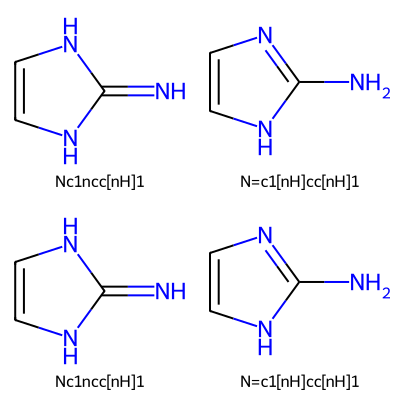

In [29]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
print(smls_tauts)
smls = [[item for item in enumerator.keys()] for enumerator in smls_tauts]
tauts = [[item for item in enumerator.values()] for enumerator in smls_tauts]

print(smls)
print(tauts)
Draw.MolsMatrixToGridImage(tauts, legendsMatrix=smls)